In [1]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
# plt.rcdefaults()

import numpy as np
from sklearn.metrics import pairwise_distances

import time_toolbox as ttb

herz_day = 0.04166667

In [2]:
data_test, y_te = ttb.read_data('data/MelbournePedestrian/MelbournePedestrian_TEST.txt')
data_train, y_tr = ttb.read_data('data/MelbournePedestrian/MelbournePedestrian_TRAIN.txt')

data_stack = np.vstack((data_train, data_test))
y = np.hstack((y_tr, y_te))

# we use the split as in the paper by Kim et al 2021 - Dynamic Clustering in Federated Learning. They use 70% of the data to compute the purity
data_70 = int(np.ceil(data_stack.shape[0] * 0.7))
np.random.seed(42)
data_70_sampling = np.random.choice(data_stack.shape[0], data_70, replace=False)
# we obtain the subset
data_stack = data_stack[data_70_sampling]
y = y[data_70_sampling]

# the number of clusters to be identified in the dataset
k_clusters = 10

print(data_stack.shape, y.shape)

(2544, 24) (2544,)


# Model benchmarks

In [3]:
print("Compute gaussian mixture model...")

avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, data_stack, _n_init=5, _method='gmm')

print("Purity of GMM clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))

Compute gaussian mixture model...
Purity of GMM clustering: 58.17 +/- 3.55


In [4]:
print("Compute hierarchical clustering...")

avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, data_stack, _method='hierarchical')

print("Purity of hierarchical clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))

Compute hierarchical clustering...
Purity of hierarchical clustering: 58.29 +/- 0.0


# Wasserstein-based clustering

In [5]:
norm_data = ttb.normalize_data(data_stack)

# we reduce the variance of the dataset
norm_data_pca = ttb.reduce_variance(norm_data, _variance=0.85)

# we compute the Fourier transform
X, support = ttb.get_fourier(norm_data_pca, _welch=False)

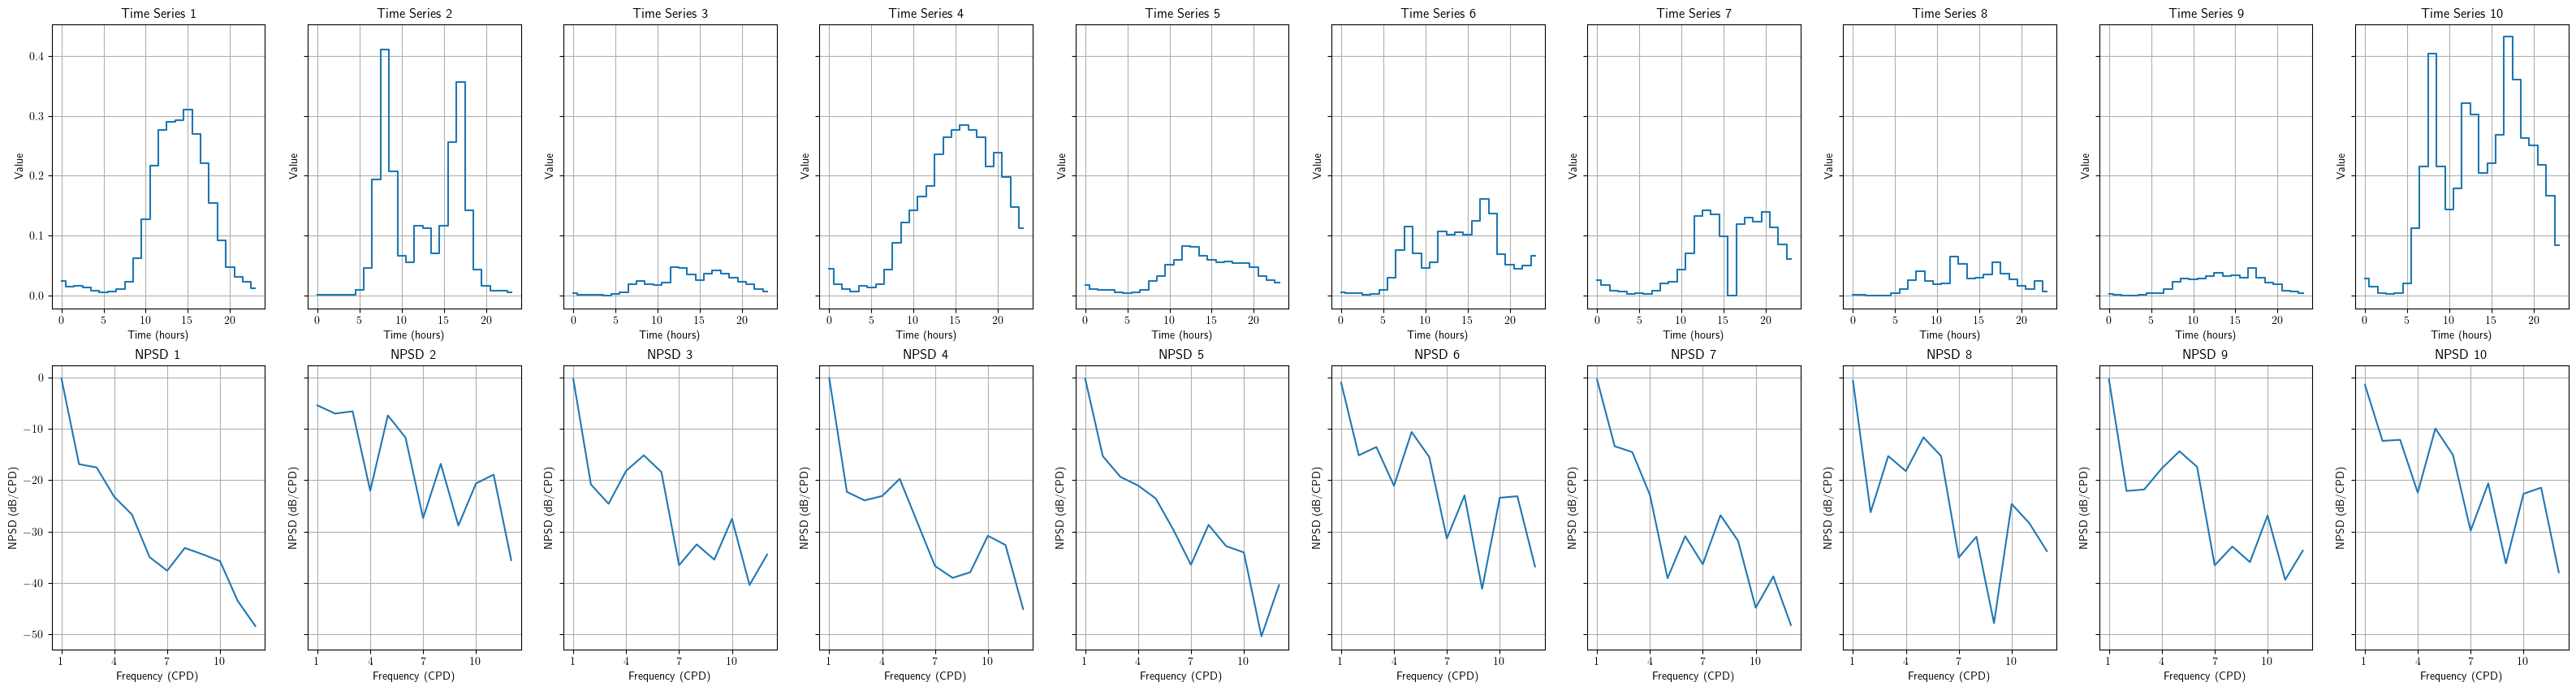

In [6]:
# we plot one time series graph and its NPSD for each data label in y_tr [1, ..., 10]
fig, ax = plt.subplots(2, 10, figsize=(40, 10), sharey='row')
# we sample graphs
y_plot = {i: np.where(y == i)[0][7] for i in range(1, 11)}
for i, yplt in y_plot.items():
    ax[0, i-1].plot(norm_data[yplt, :].T, drawstyle='steps-mid')
    # Compute and plot the NPSD
    ax[1, i-1].plot(support/herz_day, 10 * np.log10(X[yplt, :]))
    ax[0, i-1].set_title(f'Time Series {i}')
    ax[0, i-1].set_xlabel('Time (hours)')
    ax[0, i-1].set_ylabel('Value')
    ax[0, i-1].grid()
    ax[1, i-1].set_title(f'NPSD {i}')
    ax[1, i-1].set_xlabel('Frequency (CPD)')
    ax[1, i-1].set_ylabel('NPSD (dB/CPD)')
    ax[1, i-1].grid()
    ax[1, i-1].set_xticks(np.arange(1, support.size, 3))
plt.show()

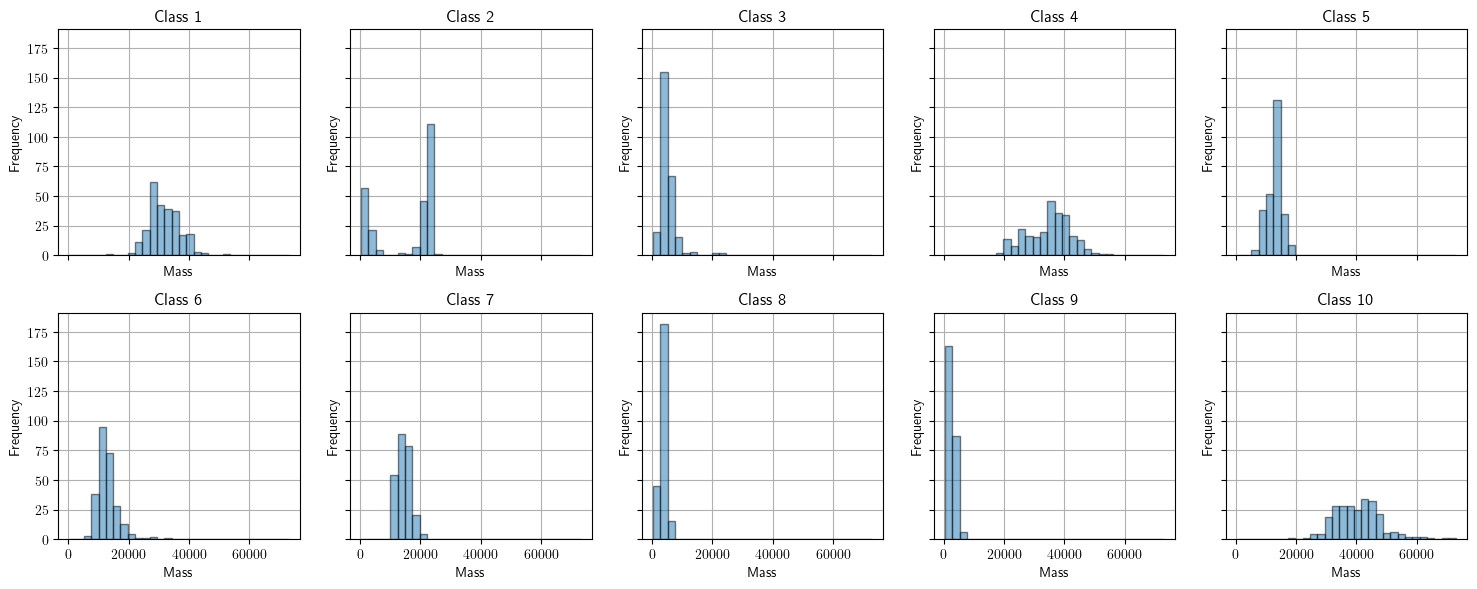

In [7]:
# we integrate the normed time series
mass = np.trapz(data_stack, axis=1)
# Compute common bins for all classes
bins = np.histogram_bin_edges(mass, bins=30)
# we plot the distribution of the mass for each class 
fig, ax = plt.subplots(2, 5, figsize=(15, 6), sharey='all', sharex='all')
for i in np.unique(y):
    ax[(i-1) // 5, (i-1) % 5].hist(
        mass[y == i],
        bins=bins,
        zorder=2,
        edgecolor='black',   # Draw black edges around bars
        alpha=0.5            # Set fill opacity (0=transparent, 1=opaque)
    )
    ax[(i-1) // 5, (i-1) % 5].set_title(f'Class {i}')
    ax[(i-1) // 5, (i-1) % 5].set_xlabel('Mass')
    ax[(i-1) // 5, (i-1) % 5].set_ylabel('Frequency')
    ax[(i-1) // 5, (i-1) % 5].grid(zorder=0)
plt.tight_layout()
plt.show()

In [8]:
Sinv, q_Sinvs = ttb.get_inverse_histograms(X, support)

In [9]:
sq_dist = pairwise_distances(q_Sinvs, metric='sqeuclidean')
mask = sq_dist > 0
indices = np.where(mask)
min_idx_flat = np.argmax(sq_dist[mask])
i_mu1, i_mu2 = indices[0][min_idx_flat], indices[1][min_idx_flat]
print((i_mu1, i_mu2))

(535, 944)


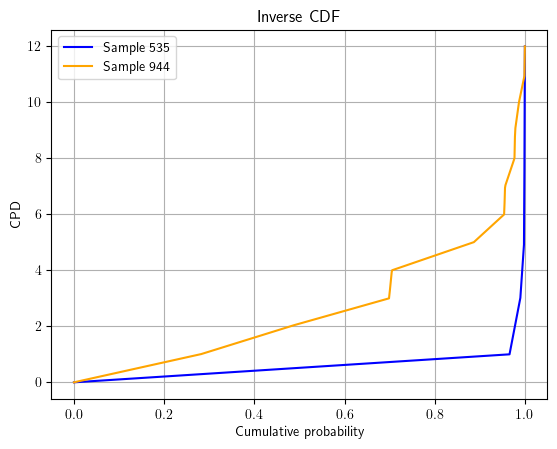

In [10]:
# we plot q_Sinv
plt.plot(Sinv, q_Sinvs[i_mu1]/herz_day, label=f'Sample {i_mu1}', color='blue')
plt.plot(Sinv, q_Sinvs[i_mu2]/herz_day, label=f'Sample {i_mu2}', color='orange')
plt.xlabel('Cumulative probability')
plt.ylabel('CPD')
plt.title('Inverse CDF')
plt.grid()
plt.legend(loc='upper left')
plt.show()

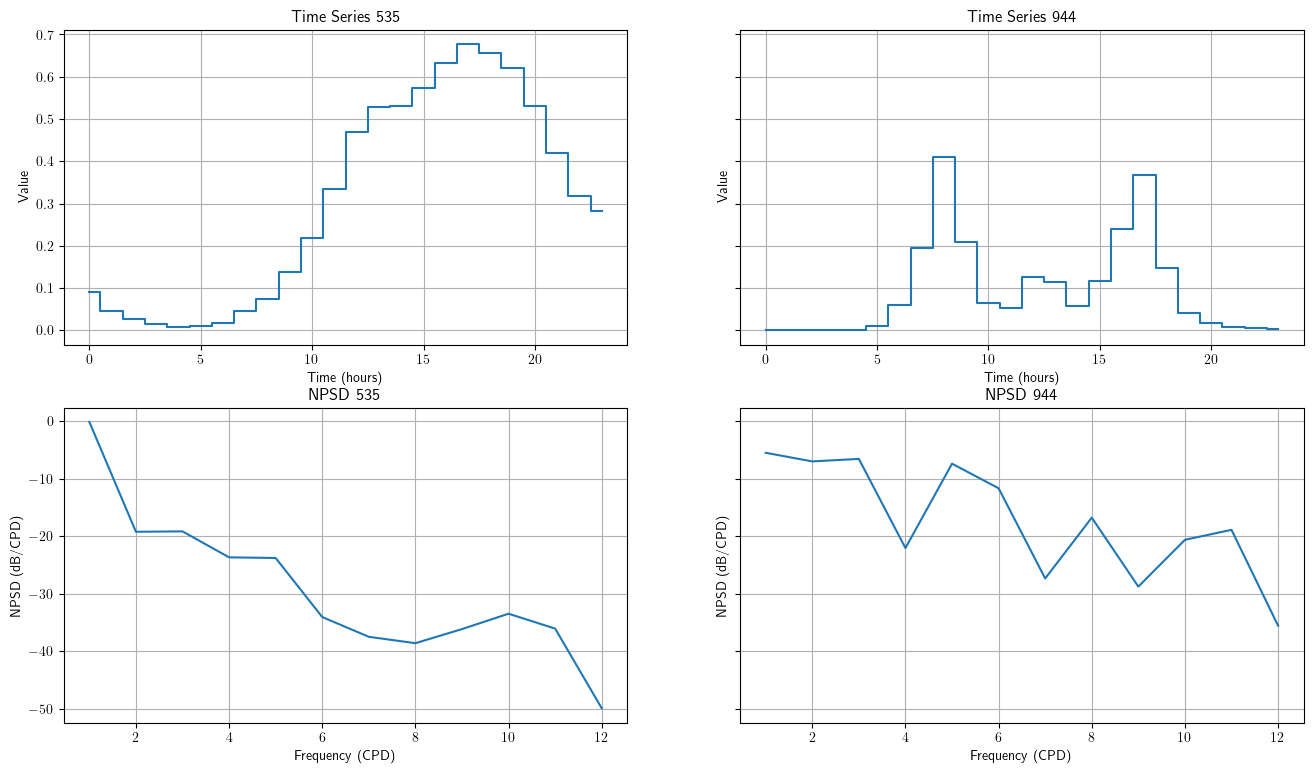

In [11]:
# we plot the time series with the most matching NPSD (i_mu1, i_mu2)
fig, ax = plt.subplots(2, 2, figsize=(16, 9), sharey='row')
# we sample graphs
for i, yplt in enumerate([i_mu1, i_mu2], start=1):
    ax[0, i-1].plot(norm_data[yplt, :].T, drawstyle='steps-mid')
    # Compute and plot the NPSD
    ax[1, i-1].plot(support/herz_day, 10 * np.log10(X[yplt, :]))
    ax[0, i-1].set_title(f'Time Series {yplt}')
    ax[0, i-1].set_xlabel('Time (hours)')
    ax[0, i-1].set_ylabel('Value')
    ax[0, i-1].grid()
    ax[1, i-1].set_title(f'NPSD {yplt}')
    ax[1, i-1].set_xlabel('Frequency (CPD)')
    ax[1, i-1].set_ylabel('NPSD (dB/CPD)')
    ax[1, i-1].grid()
plt.show()

# Kernel clustering

In [12]:
def get_gamma_max_disperion(distance_matrix, _test_range = (-9, 1, 100)):
    gammas, dispersions = ttb.optimal_dispersion_kernel(distance_matrix, test_range = _test_range)
    return gammas[np.argmax(dispersions)]

In [13]:
D_sq = {'wasserstein': pairwise_distances(q_Sinvs, metric='sqeuclidean'), 
       'mass': pairwise_distances(mass.reshape(-1, 1), metric='sqeuclidean'), 
       'euclid': pairwise_distances(norm_data, metric='sqeuclidean')}

# we find the g_wass_max parameter that maximizes the off diagonal variance
gammas = {'gamma_wasserstein': get_gamma_max_disperion(np.sqrt(D_sq['wasserstein'])),
          'gamma_mass': get_gamma_max_disperion(np.sqrt(D_sq['mass'])),
          'gamma_euclid': get_gamma_max_disperion(np.sqrt(D_sq['euclid']))}

print("Optimal gamma values:")
for key, value in gammas.items():
    print(f"{key}: {value}")

Optimal gamma values:
gamma_wasserstein: -0.010101010091602802
gamma_mass: -8.090909004211426
gamma_euclid: 0.7979797720909119


In [14]:
bayes_iter, bayes_init = 50, 50 # the number of iterations and initial points for the optimizer
eps = 1.0

print("\n-------------------------------------------\n")
print("Kaiser criterion for component selection\n")

df_results, execution_info = ttb.bayes_optimize_melbourne(gammas, D_sq, eps, bayes_init, bayes_iter, k_clusters)

g_wass, g_mass, g_euclid = df_results[['gamma_wasserstein', 'gamma_mass','gamma_euclid']].values[0]

phi_composed, variance_retained = ttb.melbourne_kernel_map(D_sq, g_wass, g_mass, g_euclid)

avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, phi_composed, _n_init=5)
print("\n-------------------------------------------\n")
print("Number of components: ", phi_composed.shape[1], "\nRetained variance: ", round(variance_retained * 100, 2), "%")
print("\nPurity of kernel clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))



-------------------------------------------

Kaiser criterion for component selection

Bayesian optimization for kernel parameters
Random point iterations:


100%|██████████| 50/50 [04:20<00:00,  5.21s/it]


Bayes point iterations:


100%|██████████| 50/50 [03:57<00:00,  4.76s/it]


Total execution time:  498.62203216552734

-------------------------------------------

Number of components:  12 
Retained variance:  99.82 %

Purity of kernel clustering: 66.59 +/- 2.4


In [15]:
# execution time per iteration
exec_times = np.array(list(execution_info.values()))
print("Min execution time:", round(np.min(exec_times),2))
print("Std. execution time:", round(np.std(exec_times),2))
print("Avg. execution time:", round(np.mean(exec_times),2))
print("Max execution time:", round(np.max(exec_times),2))

Min execution time: 4.48
Std. execution time: 0.31
Avg. execution time: 4.99
Max execution time: 6.17


# Adaptive variance kernel PCA

In [15]:
bayes_iter, bayes_init = 50, 50 # the number of iterations and initial points for the optimizer
eps = 1.0
variance = [0.90, 0.95, 0.99]

for var in variance:
    print("\n-------------------------------------------\n")
    print("Testing with variance = ", var, '\n\n')

    df_results, execution_info = ttb.bayes_optimize_melbourne(gammas, D_sq, eps, bayes_init, bayes_iter, k_clusters, var)
    g_wass, g_mass, g_euclid = df_results[['gamma_wasserstein', 'gamma_mass','gamma_euclid']].values[0]

    phi_composed, variance_retained = ttb.melbourne_kernel_map(D_sq, g_wass, g_mass, g_euclid, var)

    avg_purity, std_purity = ttb.purity_clustering(y, k_clusters, phi_composed, _n_init=5)

    print("\n-------------------------------------------\n")
    print("Number of components: ", phi_composed.shape[1], "\nRetained variance: ", round(variance_retained * 100, 2), "%")
    print("\nPurity of kernel clustering:", round(avg_purity * 100, 2), "+/-", round(std_purity * 100, 2))


-------------------------------------------

Testing with variance =  0.9 


Bayesian optimization for kernel parameters
Random point iterations:


100%|██████████| 50/50 [04:02<00:00,  4.85s/it]


Bayes point iterations:


100%|██████████| 50/50 [04:12<00:00,  5.05s/it]


Total execution time:  494.77212262153625

-------------------------------------------

Number of components:  5 
Retained variance:  90.34 %

Purity of kernel clustering: 58.98 +/- 1.55

-------------------------------------------

Testing with variance =  0.95 


Bayesian optimization for kernel parameters
Random point iterations:


100%|██████████| 50/50 [03:52<00:00,  4.65s/it]


Bayes point iterations:


100%|██████████| 50/50 [03:52<00:00,  4.65s/it]


Total execution time:  464.9253067970276

-------------------------------------------

Number of components:  9 
Retained variance:  95.69 %

Purity of kernel clustering: 72.78 +/- 1.18

-------------------------------------------

Testing with variance =  0.99 


Bayesian optimization for kernel parameters
Random point iterations:


100%|██████████| 50/50 [03:43<00:00,  4.48s/it]


Bayes point iterations:


100%|██████████| 50/50 [03:49<00:00,  4.58s/it]


Total execution time:  452.9468266963959

-------------------------------------------

Number of components:  12 
Retained variance:  99.17 %

Purity of kernel clustering: 56.67 +/- 0.29
